<h1>Imports </h1>

In [ ]:
import pandas as pd
import numpy as np 
import xgboost as xgb 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import optuna as opt

<h1>Importing the data </h1>

In [2]:
df = pd.read_csv("../datafiles/Space.csv")

<h1>Categorically Encoding "class" </h1>

In [3]:
df["class"] = df["class"].astype("category").cat.codes

In [4]:
X = df.drop(["class"], axis=1)
y = df["class"]

<h1>Train_test_split</h1>

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

<h2>Optuna hyperparameter optimalization</h1>

In [ ]:
#use optuna to tune the hyperparameters
def objective(trial):
    param = {
            "n_estimators" : trial.suggest_int('n_estimators', 0, 1000),
            'max_depth':trial.suggest_int('max_depth', 2, 25),
            'reg_alpha':trial.suggest_int('reg_alpha', 0, 5),
            'reg_lambda':trial.suggest_int('reg_lambda', 0, 5),
            'min_child_weight':trial.suggest_int('min_child_weight', 0, 5),
            'gamma':trial.suggest_int('gamma', 0, 5),
            'learning_rate':trial.suggest_loguniform('learning_rate',0.005,0.5),
            'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.1,1,0.01),
            'nthread' : -1
        }
    model = xgb.XGBClassifier(**param)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro')
    return score.mean()


study = opt.create_study(direction='maximize')
study.optimize(objective, n_trials=2)


<h2>Using optuna hyperparams to make a model and validate with f1 score</h2>

In [ ]:
# make a model with the best hyperparameters
model = xgb.XGBClassifier(**study.best_params)
model.fit(X_train, y_train)

<h2>Predicting on the test set with the model</h2>

In [8]:
y_pred = model.predict(X_test)

<h2>Using cross-validation to get an accurate score</h2>

In [ ]:
# get f1 score of the model
scores = cross_val_score(model, X, y, cv=5, scoring="f1_macro")



In [11]:
print("F1 score:", scores.mean())

F1 score: 0.9729175368337115


<h2>Plot the feature importances</h2>

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

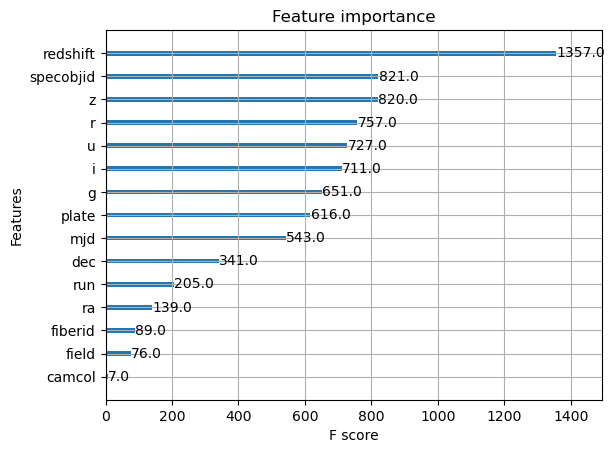

In [12]:
xgb.plot_importance(model)

<h2>Plotting the confusion matrix</h2>

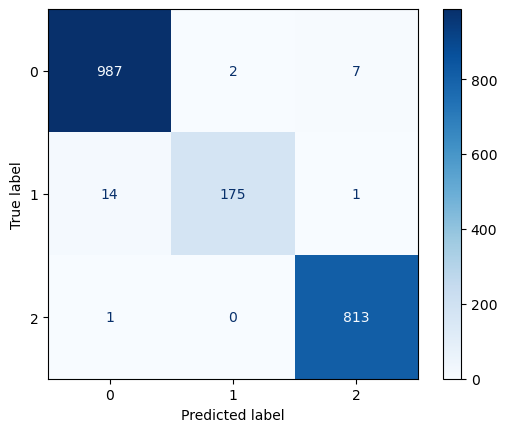

In [14]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues")